# 02 - DBSCAN 与层次聚类

> 📚 学习目标：掌握基于密度的聚类（DBSCAN）和层次聚类方法

---

## 📖 本节内容

1. **DBSCAN (Density-Based Spatial Clustering)**
   - 核心概念：密度可达、核心点、边界点、噪声点
   - 参数调优：eps和min_samples
   - 优势：不需要指定簇数量、可以发现任意形状的簇

2. **层次聚类 (Hierarchical Clustering)**
   - 凝聚式（自底向上）
   - 链接方式：单链接、全链接、平均链接、Ward方法
   - 树状图（Dendrogram）可视化

---

## 1. 环境准备

In [1]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = [
        'Arial Unicode MS',  # macOS通用
        'PingFang SC',       # macOS系统字体
        'STHeiti',           # 华文黑体
        'Heiti TC',          # 黑体-繁
        'SimHei',            # 黑体
    ]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 随机种子
np.random.seed(42)

print("✅ 环境准备完成！")

✅ 环境准备完成！


---

## 2. DBSCAN 聚类

### 2.1 核心概念

**DBSCAN的三类点**：
- 🔴 **核心点 (Core Point)**: 邻域内至少有`min_samples`个点
- 🟡 **边界点 (Border Point)**: 不是核心点，但在某个核心点的邻域内
- ⚫ **噪声点 (Noise Point)**: 既不是核心点也不是边界点

**关键参数**：
- `eps`：邻域半径（epsilon）
- `min_samples`：成为核心点所需的最小邻居数

---

### 2.2 生成测试数据

使用月牙形数据（K-Means难以处理）

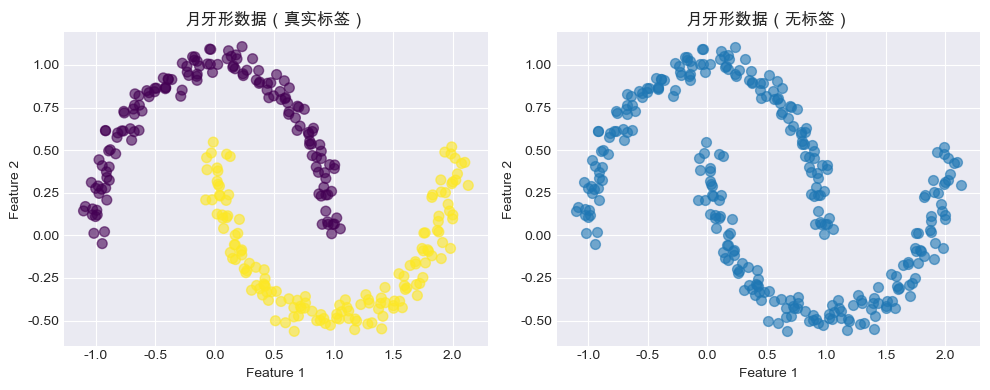

数据形状: (300, 2)
真实簇数: 2


In [2]:
# 生成月牙形数据
X_moons, y_true = make_moons(n_samples=300, noise=0.05, random_state=42)

# 标准化
scaler = StandardScaler()
X_moons_scaled = scaler.fit_transform(X_moons)

# 可视化原始数据
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_true, cmap='viridis', s=50, alpha=0.6)
plt.title('月牙形数据（真实标签）')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(X_moons[:, 0], X_moons[:, 1], s=50, alpha=0.6)
plt.title('月牙形数据（无标签）')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

print(f"数据形状: {X_moons.shape}")
print(f"真实簇数: {len(np.unique(y_true))}")

### 2.3 使用DBSCAN聚类

In [3]:
# 创建DBSCAN模型
dbscan = DBSCAN(
    eps=0.3,           # 邻域半径
    min_samples=5      # 最小样本数
)

# 训练并预测
labels_dbscan = dbscan.fit_predict(X_moons_scaled)

# 统计结果
n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)

print(f"发现的簇数量: {n_clusters}")
print(f"噪声点数量: {n_noise}")
print(f"\n每个簇的样本数:")
unique, counts = np.unique(labels_dbscan, return_counts=True)
for label, count in zip(unique, counts):
    if label == -1:
        print(f"  噪声点: {count}")
    else:
        print(f"  簇 {label}: {count}")

发现的簇数量: 2
噪声点数量: 0

每个簇的样本数:
  簇 0: 150
  簇 1: 150


### 2.4 可视化DBSCAN结果

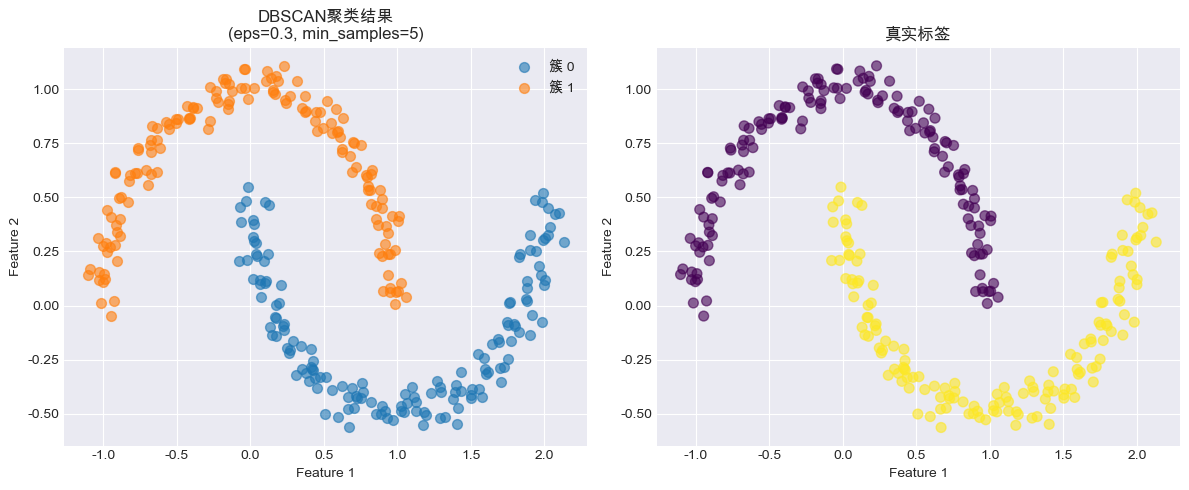

In [4]:
# 可视化聚类结果
plt.figure(figsize=(12, 5))

# DBSCAN结果
plt.subplot(1, 2, 1)
# 绘制非噪声点
for label in set(labels_dbscan):
    if label == -1:
        # 噪声点用黑色×标记
        mask = labels_dbscan == label
        plt.scatter(X_moons[mask, 0], X_moons[mask, 1], 
                   c='black', marker='x', s=50, label='噪声点')
    else:
        mask = labels_dbscan == label
        plt.scatter(X_moons[mask, 0], X_moons[mask, 1], 
                   s=50, alpha=0.6, label=f'簇 {label}')

plt.title(f'DBSCAN聚类结果\n(eps={dbscan.eps}, min_samples={dbscan.min_samples})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# 真实标签对比
plt.subplot(1, 2, 2)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_true, cmap='viridis', s=50, alpha=0.6)
plt.title('真实标签')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

### 2.5 参数调优：eps的影响

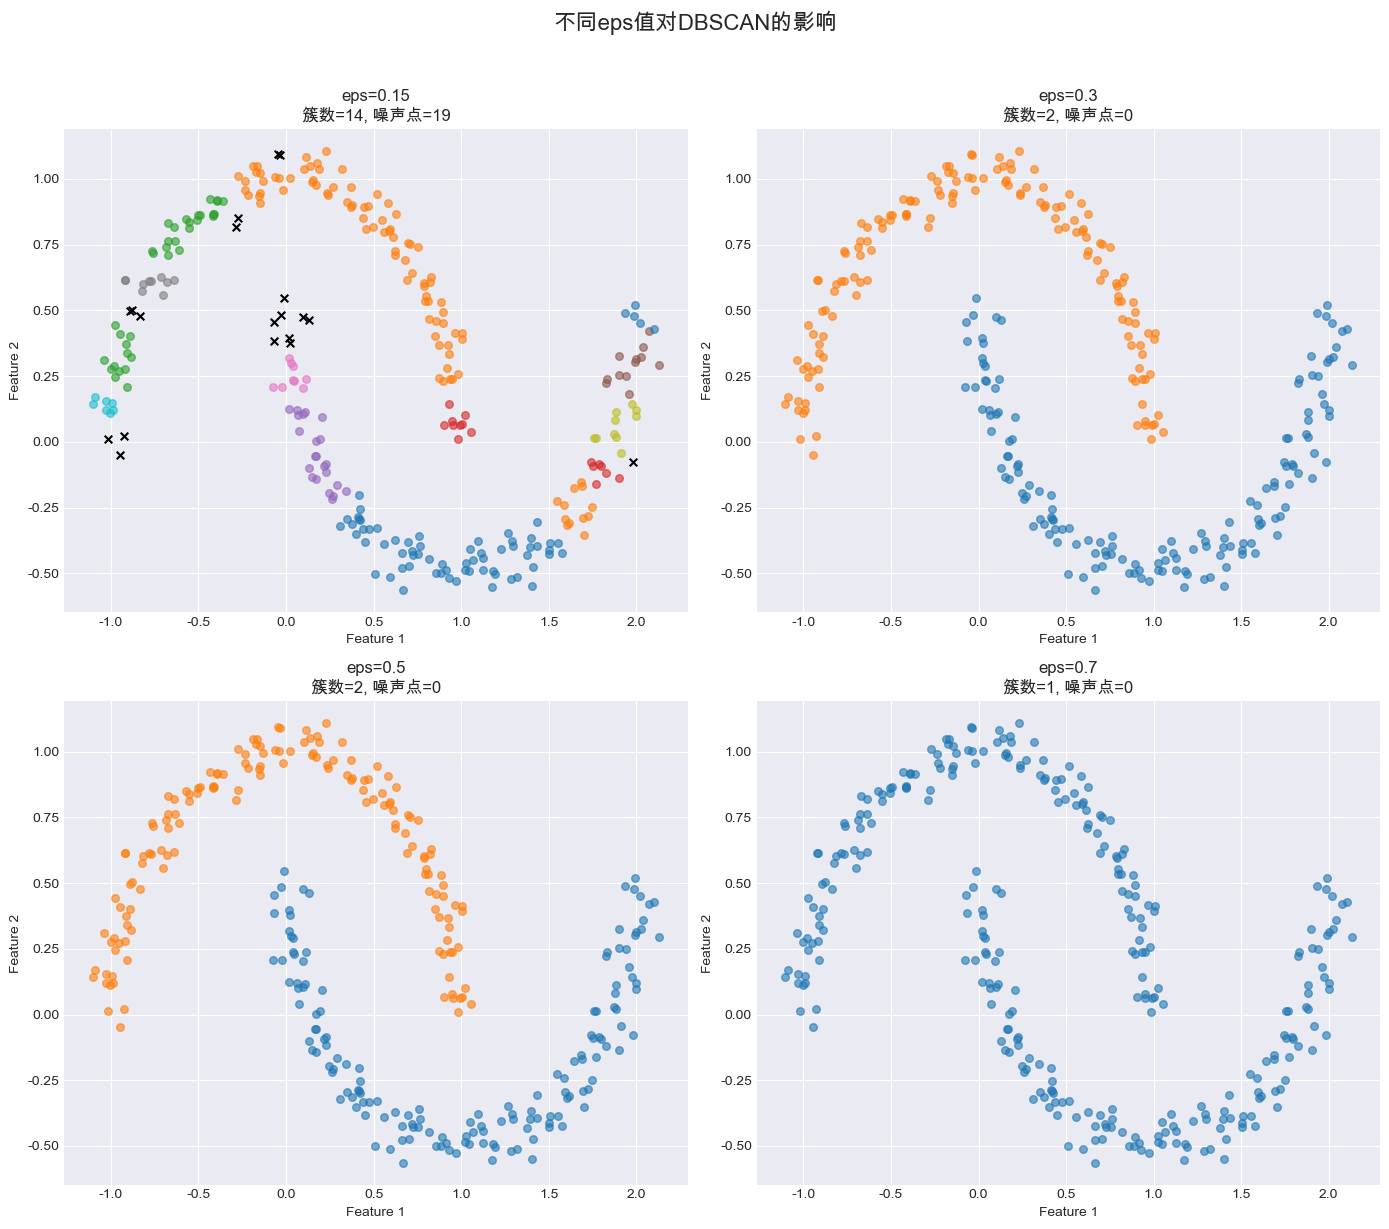

In [5]:
# 测试不同的eps值
eps_values = [0.15, 0.3, 0.5, 0.7]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, eps in enumerate(eps_values):
    # DBSCAN聚类
    dbscan_temp = DBSCAN(eps=eps, min_samples=5)
    labels_temp = dbscan_temp.fit_predict(X_moons_scaled)
    
    # 统计
    n_clusters_temp = len(set(labels_temp)) - (1 if -1 in labels_temp else 0)
    n_noise_temp = list(labels_temp).count(-1)
    
    # 绘图
    ax = axes[idx]
    for label in set(labels_temp):
        if label == -1:
            mask = labels_temp == label
            ax.scatter(X_moons[mask, 0], X_moons[mask, 1], 
                      c='black', marker='x', s=30)
        else:
            mask = labels_temp == label
            ax.scatter(X_moons[mask, 0], X_moons[mask, 1], s=30, alpha=0.6)
    
    ax.set_title(f'eps={eps}\n簇数={n_clusters_temp}, 噪声点={n_noise_temp}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

plt.suptitle('不同eps值对DBSCAN的影响', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### 2.6 DBSCAN vs K-Means对比

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


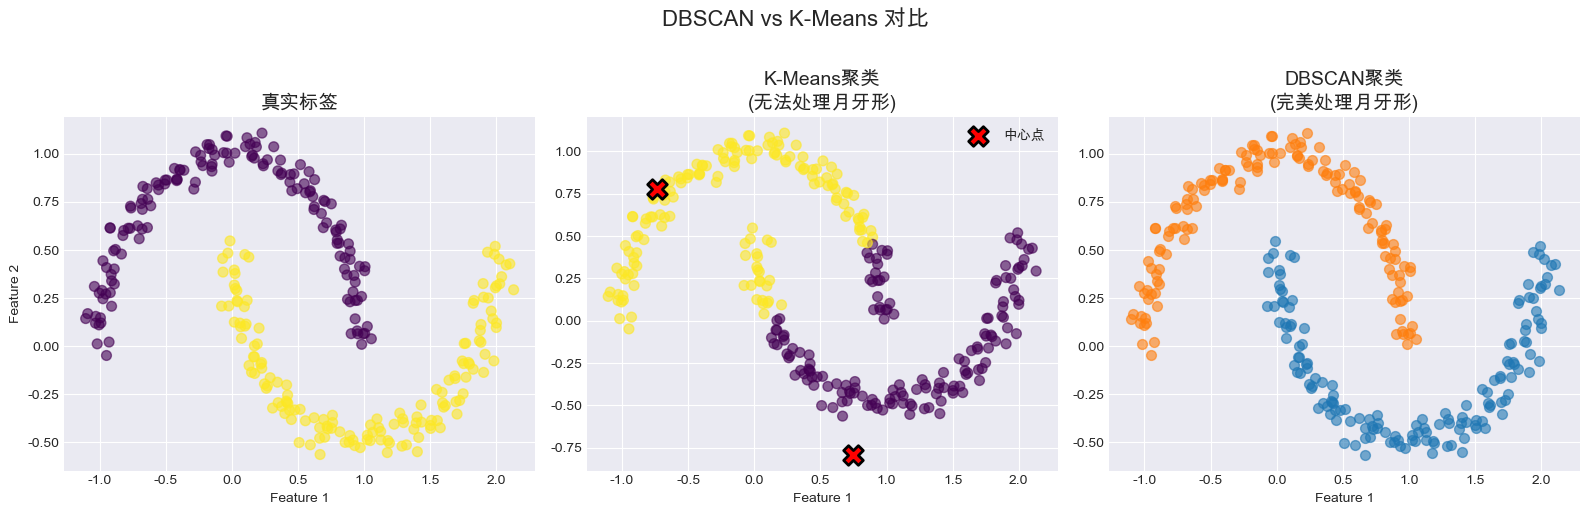


✅ DBSCAN的优势：
  1. 可以发现任意形状的簇（如月牙形）
  2. 不需要预先指定簇的数量
  3. 能够识别噪声点

⚠️ DBSCAN的局限：
  1. 需要手动调整eps和min_samples参数
  2. 对不同密度的簇效果不好


In [7]:
from sklearn.cluster import KMeans

# K-Means聚类
kmeans = KMeans(n_clusters=2, random_state=42)
labels_kmeans = kmeans.fit_predict(X_moons_scaled)

# 对比可视化
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 真实标签
axes[0].scatter(X_moons[:, 0], X_moons[:, 1], c=y_true, cmap='viridis', s=50, alpha=0.6)
axes[0].set_title('真实标签', fontsize=14)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# K-Means结果
axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=labels_kmeans, cmap='viridis', s=50, alpha=0.6)
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
               c='red', marker='X', s=200, edgecolors='black', linewidths=2, label='中心点')
axes[1].set_title('K-Means聚类\n(无法处理月牙形)', fontsize=14)
axes[1].set_xlabel('Feature 1')
axes[1].legend()

# DBSCAN结果
for label in set(labels_dbscan):
    if label == -1:
        mask = labels_dbscan == label
        axes[2].scatter(X_moons[mask, 0], X_moons[mask, 1], 
                       c='black', marker='x', s=50, label='噪声')
    else:
        mask = labels_dbscan == label
        axes[2].scatter(X_moons[mask, 0], X_moons[mask, 1], s=50, alpha=0.6)

axes[2].set_title('DBSCAN聚类\n(完美处理月牙形)', fontsize=14)
axes[2].set_xlabel('Feature 1')
axes[2].legend()

plt.suptitle('DBSCAN vs K-Means 对比', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\n✅ DBSCAN的优势：")
print("  1. 可以发现任意形状的簇（如月牙形）")
print("  2. 不需要预先指定簇的数量")
print("  3. 能够识别噪声点")
print("\n⚠️ DBSCAN的局限：")
print("  1. 需要手动调整eps和min_samples参数")
print("  2. 对不同密度的簇效果不好")

---

## 3. 层次聚类 (Hierarchical Clustering)

### 3.1 核心概念

**两种策略**：
- 🔼 **凝聚式 (Agglomerative)**: 自底向上，每个点从单独一簇开始，逐步合并
- 🔽 **分裂式 (Divisive)**: 自顶向下，从一个大簇开始，逐步分裂

**链接方式 (Linkage)**：
- `single`: 单链接（最小距离）
- `complete`: 全链接（最大距离）
- `average`: 平均链接
- `ward`: Ward方法（最小化方差）⭐ 推荐

---

### 3.2 生成测试数据

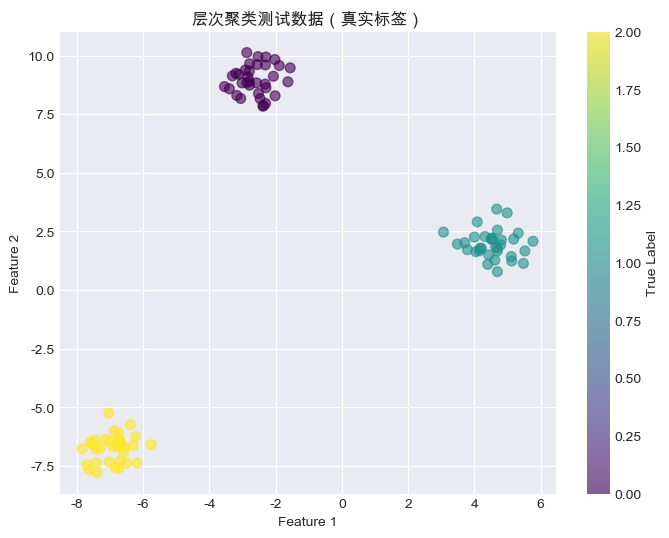

数据形状: (100, 2)
真实簇数: 3


In [8]:
# 生成简单的blob数据用于层次聚类演示
X_blob, y_blob = make_blobs(
    n_samples=100,
    centers=3,
    n_features=2,
    cluster_std=0.6,
    random_state=42
)

# 可视化
plt.figure(figsize=(8, 6))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap='viridis', s=50, alpha=0.6)
plt.title('层次聚类测试数据（真实标签）')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='True Label')
plt.show()

print(f"数据形状: {X_blob.shape}")
print(f"真实簇数: {len(np.unique(y_blob))}")

### 3.3 绘制树状图 (Dendrogram)

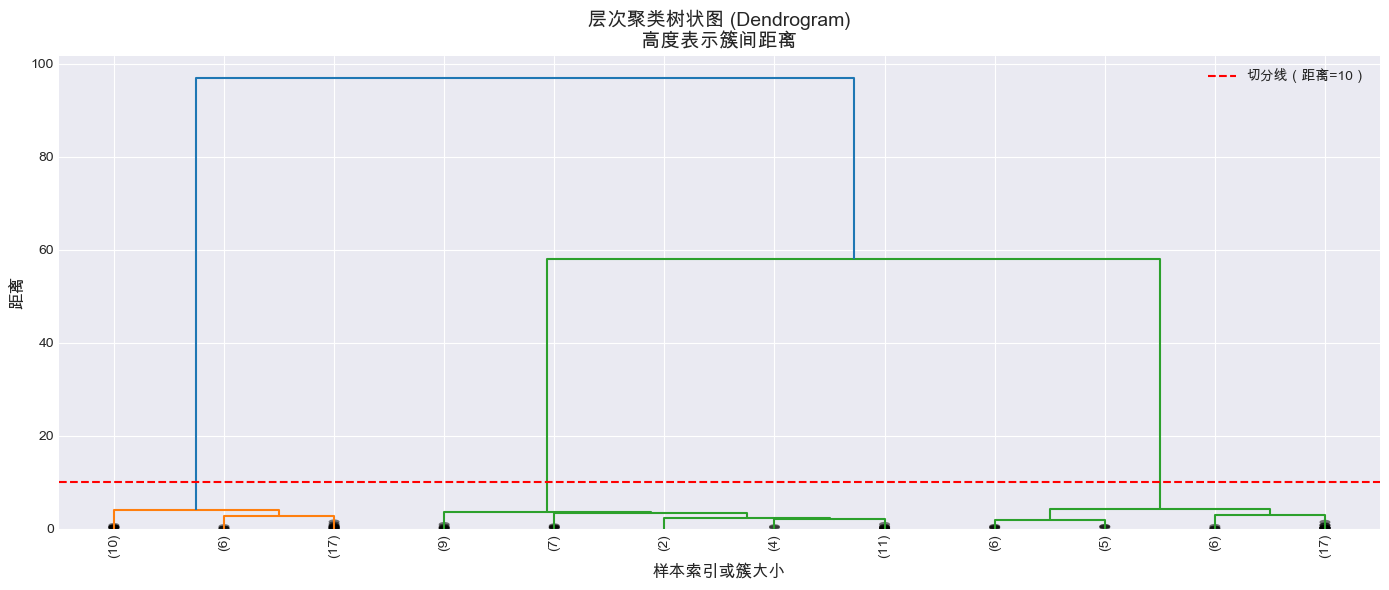


📖 树状图解读：
  - 横轴：样本或簇的编号
  - 纵轴：合并时的距离（高度）
  - 横线：簇的合并
  - 红色虚线：切分阈值，决定最终簇数


In [9]:
# 计算链接矩阵
linkage_matrix = linkage(X_blob, method='ward')

# 绘制树状图
plt.figure(figsize=(14, 6))

dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # 只显示最后p个合并
    p=12,                   # 显示最后12个合并
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True
)

plt.title('层次聚类树状图 (Dendrogram)\n高度表示簇间距离', fontsize=14)
plt.xlabel('样本索引或簇大小', fontsize=12)
plt.ylabel('距离', fontsize=12)
plt.axhline(y=10, c='red', linestyle='--', label='切分线（距离=10）')
plt.legend()
plt.tight_layout()
plt.show()

print("\n📖 树状图解读：")
print("  - 横轴：样本或簇的编号")
print("  - 纵轴：合并时的距离（高度）")
print("  - 横线：簇的合并")
print("  - 红色虚线：切分阈值，决定最终簇数")

### 3.4 使用凝聚式层次聚类

In [10]:
# 创建层次聚类模型
hierarchical = AgglomerativeClustering(
    n_clusters=3,       # 指定簇数量
    linkage='ward'      # 使用Ward链接
)

# 训练并预测
labels_hierarchical = hierarchical.fit_predict(X_blob)

print(f"簇数量: {hierarchical.n_clusters}")
print(f"\n每个簇的样本数:")
unique, counts = np.unique(labels_hierarchical, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  簇 {label}: {count}")

簇数量: 3

每个簇的样本数:
  簇 0: 34
  簇 1: 33
  簇 2: 33


### 3.5 可视化层次聚类结果

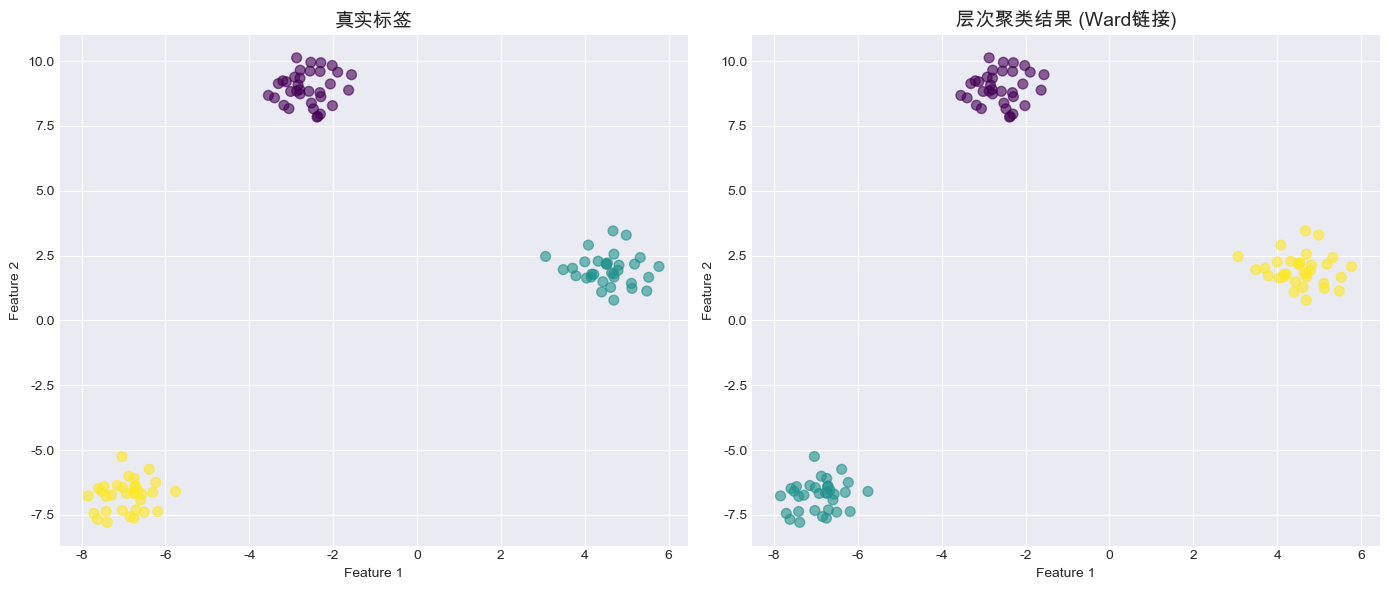

In [11]:
# 对比可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 真实标签
axes[0].scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap='viridis', s=50, alpha=0.6)
axes[0].set_title('真实标签', fontsize=14)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# 层次聚类结果
axes[1].scatter(X_blob[:, 0], X_blob[:, 1], c=labels_hierarchical, cmap='viridis', s=50, alpha=0.6)
axes[1].set_title('层次聚类结果 (Ward链接)', fontsize=14)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

### 3.6 不同链接方式对比

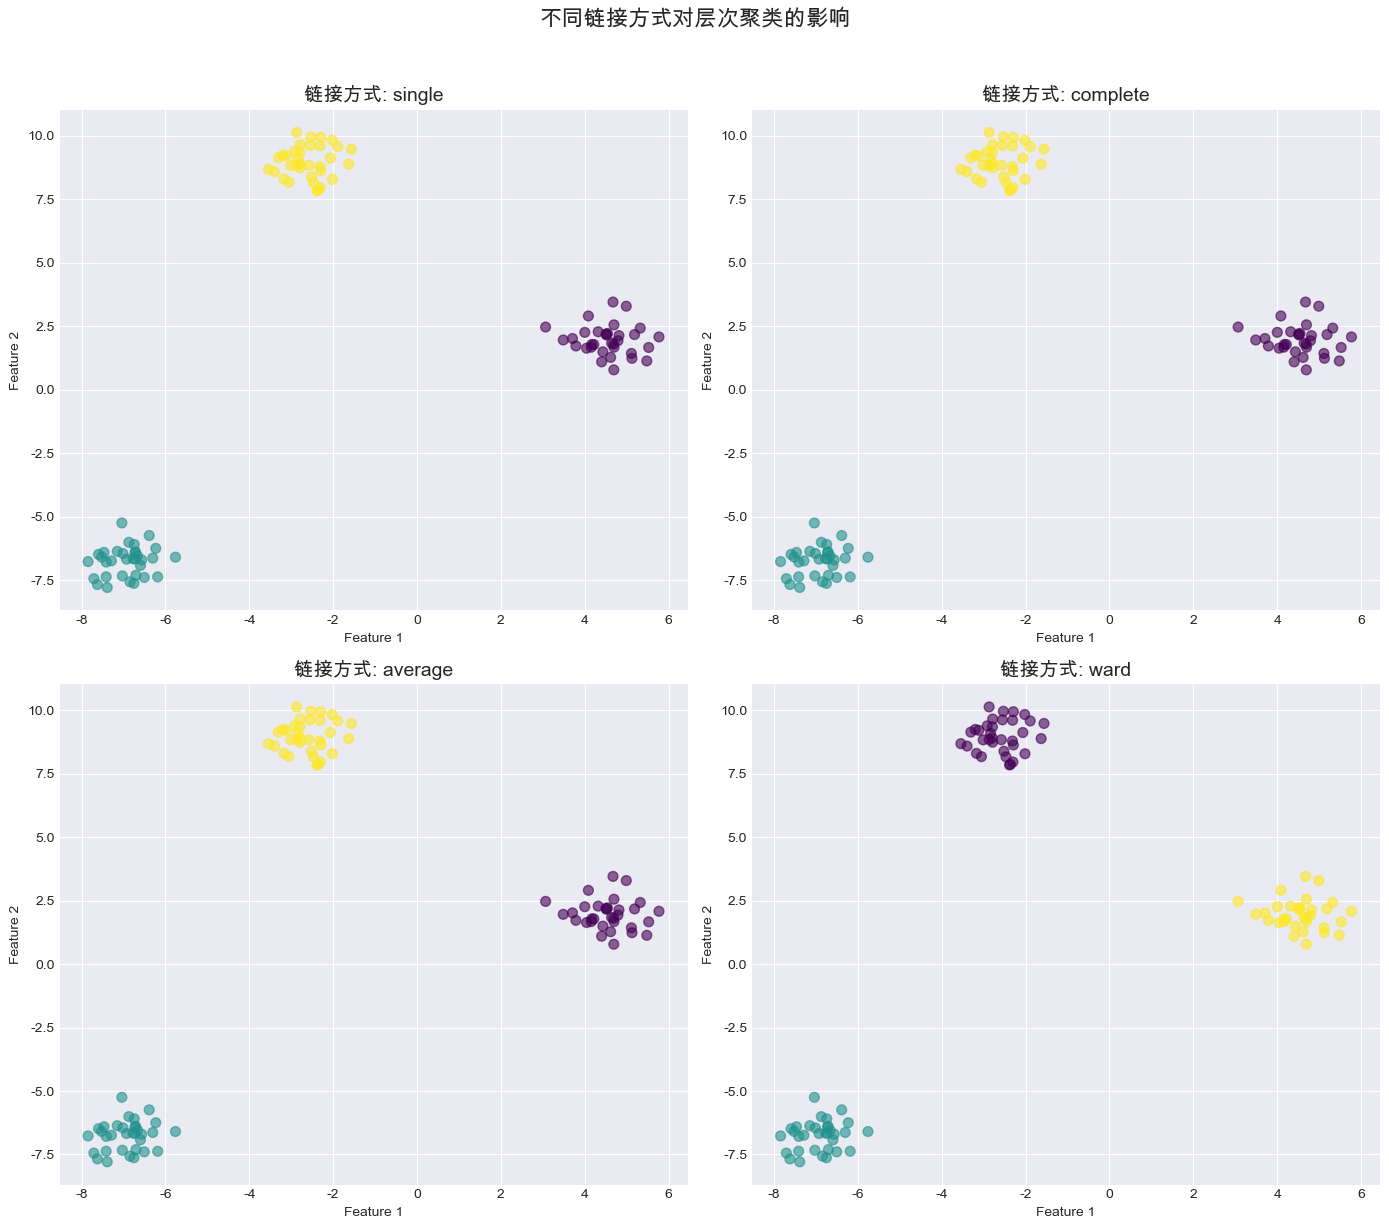


📊 链接方式说明：
  - single: 单链接（最近点距离）- 容易产生链状簇
  - complete: 全链接（最远点距离）- 倾向于球形簇
  - average: 平均链接（平均距离）- 折中方案
  - ward: Ward方法（最小化方差）- 通常效果最好 ⭐


In [12]:
# 测试不同的链接方式
linkage_methods = ['single', 'complete', 'average', 'ward']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, method in enumerate(linkage_methods):
    # 层次聚类
    hierarchical_temp = AgglomerativeClustering(n_clusters=3, linkage=method)
    labels_temp = hierarchical_temp.fit_predict(X_blob)
    
    # 绘图
    axes[idx].scatter(X_blob[:, 0], X_blob[:, 1], c=labels_temp, cmap='viridis', s=50, alpha=0.6)
    axes[idx].set_title(f'链接方式: {method}', fontsize=14)
    axes[idx].set_xlabel('Feature 1')
    axes[idx].set_ylabel('Feature 2')

plt.suptitle('不同链接方式对层次聚类的影响', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 链接方式说明：")
print("  - single: 单链接（最近点距离）- 容易产生链状簇")
print("  - complete: 全链接（最远点距离）- 倾向于球形簇")
print("  - average: 平均链接（平均距离）- 折中方案")
print("  - ward: Ward方法（最小化方差）- 通常效果最好 ⭐")

---

## 4. 综合对比：三种聚类算法

对比K-Means、DBSCAN、层次聚类在不同数据集上的表现

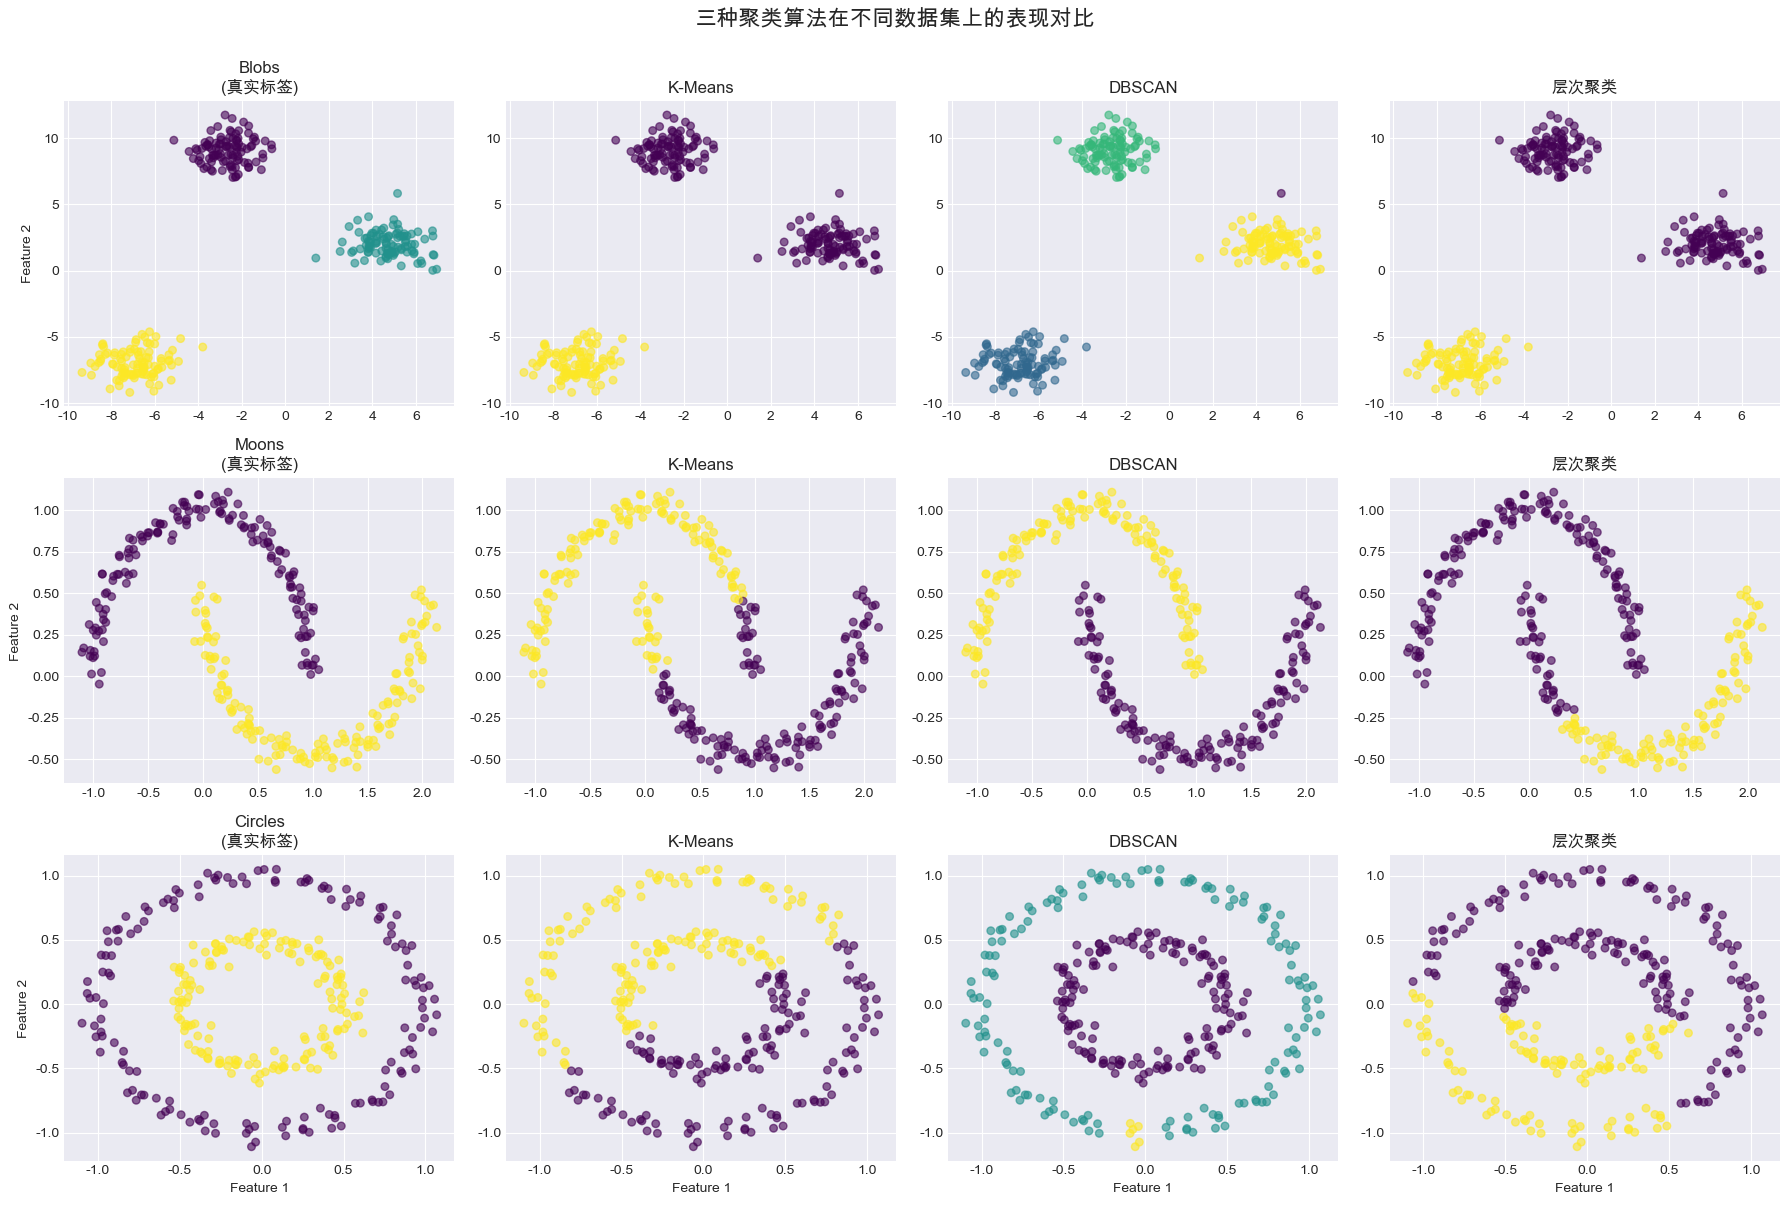

In [13]:
# 生成3种不同形状的数据集
datasets = [
    ('Blobs', make_blobs(n_samples=300, centers=3, random_state=42)),
    ('Moons', make_moons(n_samples=300, noise=0.05, random_state=42)),
    ('Circles', make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42))
]

# 创建子图
fig, axes = plt.subplots(3, 4, figsize=(18, 12))

for row, (name, (X, y)) in enumerate(datasets):
    # 标准化
    X_scaled = StandardScaler().fit_transform(X)
    
    # 原始数据
    axes[row, 0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=30, alpha=0.6)
    axes[row, 0].set_title(f'{name}\n(真实标签)', fontsize=12)
    axes[row, 0].set_ylabel('Feature 2')
    if row == 2:
        axes[row, 0].set_xlabel('Feature 1')
    
    # K-Means
    kmeans_temp = KMeans(n_clusters=2, random_state=42)
    labels_km = kmeans_temp.fit_predict(X_scaled)
    axes[row, 1].scatter(X[:, 0], X[:, 1], c=labels_km, cmap='viridis', s=30, alpha=0.6)
    axes[row, 1].set_title('K-Means', fontsize=12)
    if row == 2:
        axes[row, 1].set_xlabel('Feature 1')
    
    # DBSCAN
    dbscan_temp = DBSCAN(eps=0.3, min_samples=5)
    labels_db = dbscan_temp.fit_predict(X_scaled)
    axes[row, 2].scatter(X[:, 0], X[:, 1], c=labels_db, cmap='viridis', s=30, alpha=0.6)
    axes[row, 2].set_title('DBSCAN', fontsize=12)
    if row == 2:
        axes[row, 2].set_xlabel('Feature 1')
    
    # 层次聚类
    hierarchical_temp = AgglomerativeClustering(n_clusters=2, linkage='ward')
    labels_hc = hierarchical_temp.fit_predict(X_scaled)
    axes[row, 3].scatter(X[:, 0], X[:, 1], c=labels_hc, cmap='viridis', s=30, alpha=0.6)
    axes[row, 3].set_title('层次聚类', fontsize=12)
    if row == 2:
        axes[row, 3].set_xlabel('Feature 1')

plt.suptitle('三种聚类算法在不同数据集上的表现对比', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

---

## 5. 总结与对比

### 算法特点对比

| 特性 | K-Means | DBSCAN | 层次聚类 |
|------|---------|--------|----------|
| **簇形状** | 球形 | 任意形状 | 任意形状 |
| **需要指定簇数** | 是 | 否 | 是 |
| **噪声处理** | 无 | 能识别噪声 | 无 |
| **时间复杂度** | O(nkt) | O(n log n) | O(n²) |
| **适用场景** | 大规模、球形簇 | 任意形状、有噪声 | 小规模、需要层次结构 |
| **参数调优** | K值 | eps, min_samples | 簇数、链接方式 |

### 选择建议

```python
选择K-Means 当:
  ✅ 数据规模大
  ✅ 簇呈球形分布
  ✅ 知道大概的簇数量

选择DBSCAN 当:
  ✅ 簇形状不规则
  ✅ 不知道簇的数量
  ✅ 数据中有噪声
  ✅ 不同簇密度相似

选择层次聚类 当:
  ✅ 需要层次结构
  ✅ 数据规模较小
  ✅ 需要可视化聚类过程
```

---

## 🎯 练习任务

1. ✅ 尝试不同的DBSCAN参数组合，观察对结果的影响
2. ✅ 使用肘部法则结合树状图确定最佳簇数
3. ✅ 在Iris数据集上对比三种聚类算法
4. ✅ 实现一个函数，自动选择最优的eps参数

---

## 📚 参考资源

- [DBSCAN论文](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)
- [Scikit-learn聚类文档](https://scikit-learn.org/stable/modules/clustering.html)
- [层次聚类可视化工具](https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_hierarchical_clustering.html)

---

**下一节**: `03_gmm.ipynb` - 高斯混合模型（概率聚类）

**完成！** ✅